In [94]:
from crim_intervals import *
import pandas as pd
import ast
import matplotlib
from itertools import tee, combinations
import numpy as np

In [95]:
# THIS IS DEV COPY for use with CLOSE/EXACT Matches

import numpy as np

# Converts lists to tuples

def lists_to_tuples_a(el):
    if isinstance(el, list):
        return tuple(el)
    else:
        return el

# Filters for the length of the Presentation Type in the Classifier

def limit_offset_size(array, limit):
    under_limit = np.cumsum(array) <= limit
    return array[: sum(under_limit)]

# Gets the the list of offset differences for each group 

def get_offset_difference_list_a(group):
    # if we do sort values as part of the func call, then we don't need this first line
    group = group.sort_values("start_offset")
    group["next_offset"] = group.start_offset.shift(-1)
    offset_difference_list = (group.next_offset - group.start_offset).dropna().tolist()
    return offset_difference_list

# The classifications are done here
# be sure to have the offset difference limit set here and matched in gap check below  80 = ten bars

def classify_offsets_a(offset_difference_list):
    """
    Put logic for classifying an offset list here
    """
    # 
    offset_difference_list = limit_offset_size(offset_difference_list, 500)
    
    alt_list = offset_difference_list[::2]
    
    if len(set(offset_difference_list)) == 1 and len(offset_difference_list) > 1:
        return ("PEN", offset_difference_list)
    # elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1):
    elif (len(offset_difference_list) %2 != 0) and (len(set(alt_list)) == 1) and (len(offset_difference_list) >= 3):
        return ("ID", offset_difference_list)
    elif len(offset_difference_list) >= 1:
        return ("Fuga", offset_difference_list)
    else: 
        return ("Singleton", offset_difference_list)
    
# adds predicted type, offsets and entry numbers to the results

def predict_type_a(group):
    offset_differences = get_offset_difference_list_a(group)
    predicted_type, offsets = classify_offsets_a(offset_differences)

    group["predicted_type"] = [predicted_type for i in range(len(group))]
    group["offset_diffs"] = [offsets for i in range(len(group))]
    group["entry_number"] = [i + 1 for i in range(len(group))]

    return group

In [96]:
# read CSV output of CRIM Intervals Search.

df = pd.read_csv(('A_Test_Files/Gombert.csv'), index_col=0)
df = df.drop(columns=["ema", "ema_url", "end_measure", "end_beat"])
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 614 entries, 0 to 613
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   pattern_generating_match  614 non-null    object 
 1   pattern_matched           614 non-null    object 
 2   piece_title               614 non-null    object 
 3   part                      614 non-null    object 
 4   start_measure             614 non-null    int64  
 5   start_beat                614 non-null    object 
 6   start_offset              614 non-null    float64
 7   end_offset                614 non-null    float64
 8   note_durations            614 non-null    object 
 9   sum_durs                  614 non-null    float64
dtypes: float64(3), int64(1), object(6)
memory usage: 52.8+ KB


In [99]:
# lists for views.  These are used when calling the df below

simple_view = ["piece_title", "part", "pattern_generating_match", "pattern_matched", "start_offset"]

offset_details = ["start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

drop_cols = ["pattern_matched", "part", "pattern_generating_match", "piece_title", "start_measure", "start_beat", "end_offset", "note_durations", "prev_entry_off", "next_entry_off"]

ready_classify = ["pattern_generating_match", "pattern_matched", "piece_title", "part", "start_measure", "start_beat", "start_offset", "sub_group_id", "is_first"]

In [98]:
try:
    df['note_durations'] = df.note_durations.apply(ast.literal_eval)
except:
    pass
df["sum_durs"] = df.note_durations.apply(sum)

TypeError: unsupported operand type(s) for +: 'int' and 'str'

In [100]:
# now process the original match data df by:
# sorting by start offset, then group by pattern generating match and applying the function above for prev entry
# also give each group a number
# sort by group number and start offset
# so that we can find PARALLEL (=0) Forward Gaps (the distance to NEXT entry), and Backward Gaps (distance to PREVIOUS Entry)
# All Proximate Matches are part of same sub Group (and go to classifier)
# Parallels are part of Sub Group but NOT part of Classified.  We will filter them OUT before classification
# Forward ONLY means the NEXT entry is a GAP.  No problem for Forward ONLY, since these are part of the previous set.
# Backward ONLY means the LAST entry was a GAP.  So these are NEW subgroups, since a new Presentation Type begins
# Forward AND Backward Gaps are SINGLETONS:  We will filter then OUT before Classification
# If an entry is the LAST in a Group and also has a BACKWARD gap it is also a SINGLETON

df2 = df

# Make Groups, Sort By Group and Offset, then and Add Previous/Next
df2["group_number"] = df2.groupby('pattern_matched').ngroup()
df2 = df2.sort_values(['group_number', 'start_offset'])
df2["prev_entry_off"] = df2["start_offset"].shift(1)
df2["next_entry_off"] = df2["start_offset"].shift(-1)


first_of_group = df2.drop_duplicates(subset=["pattern_matched"], keep='first').index
df2["is_first"] = df2.index.isin(first_of_group)
last_of_group = df2.drop_duplicates(subset=["pattern_matched"], keep='last').index
df2["is_last"] = df2.index.isin(last_of_group)

# Check Differences between Next and Last Offset

df2["last_off_diff"] = df2["start_offset"] - df2["prev_entry_off"]
df2["next_off_diff"] = df2["next_entry_off"] - df2["start_offset"]

# Find Parallel Entries 
df2["parallel"] = df2["last_off_diff"] == 0

# Set Gap Limits and Check Gaps Forward and Back
df2["forward_gapped"] = df2["next_off_diff"] >= 50
df2["back_gapped"] = df2["last_off_diff"] >= 50

# Find Singletons and Split Groups with Gaps
df2["singleton"] = ((df2['forward_gapped'] == True) & (df2['back_gapped'] == True) | (df2['back_gapped'] == True) & (df2["is_last"]))
df2["split_group"] = (df2['forward_gapped'] == False) & (df2['back_gapped'] == True)

#Mask Out Parallels and Singletons
df2 = df2[df2["parallel"] != True]
df2 = df2[df2["singleton"] != True]
df2["next_off_diff"] = df2["next_off_diff"].abs()
df2["last_off_diff"] = df2["last_off_diff"].abs()

# Find Final Groups
df2["combined_group"] = (df2.split_group | df2.is_first)
df2.loc[(df2["combined_group"]), "sub_group_id"] = range(df2.combined_group.sum())
df2["sub_group_id"] = df2["sub_group_id"].ffill()



<AxesSubplot:>

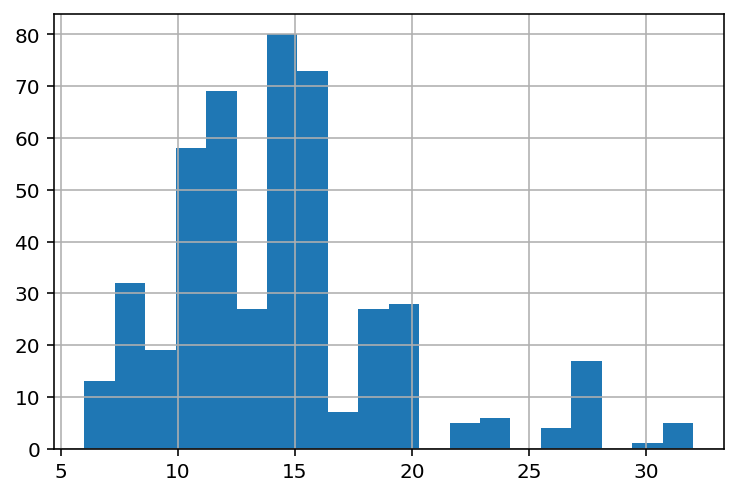

In [101]:
df2.sum_durs.hist(bins = 20)

In [102]:
# mask out short soggetti

df2 = df2[df2["sum_durs"] >= 0]


In [103]:
# compact view for inspection of relevant columns

df3 = df2[ready_classify]
df3.shape

(471, 9)

In [104]:
# run the classifier on the newly curated list of groups

classified2 = df3.applymap(lists_to_tuples_a).groupby("sub_group_id").apply(predict_type_a)

# drop the new singletons

# classified2.drop(classified2[classified2['predicted_type'] == "Singleton"].index, inplace = True)

# classified2 = classified2[classified2["predicted_type"] == "Fuga"]

classified2["start"] = classified2["start_measure"].astype(str) +"/"+ classified2["start_beat"].astype(str) 
classified2.drop(columns=['start_measure', 'start_beat','offset_diffs'], inplace=True)



In [105]:
# put things back in order by offset and group them again

classified2.sort_values(by = ["start_offset"], inplace=True)
c3 = classified2.groupby(by = ["sub_group_id"])
c3 = c3.head()

In [106]:
# Now transform as Pivot Table
pivot_c3 = c3.pivot_table(index=["piece_title", "pattern_matched", "predicted_type", "sub_group_id"],
            columns="entry_number",
            values=["part", "start_offset", "start"],
            aggfunc=lambda x: x)
pivot_c3_sort = pivot_c3.sort_values(by = [("start_offset", 1)])
pivot_c3_sort = pivot_c3_sort.fillna("-")
pivot_c3_sort.head()


part  \
entry_number                                                                 1   
piece_title             pattern_matched     predicted_type sub_group_id          
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          Altus   
                        [-2, -2, 4, -2, 2]  Fuga           46.0          Altus   
                        [-2, 4, -2, 2, 2]   Fuga           78.0          Altus   
                        [4, -2, 2, 2, -5]   Fuga           187.0         Altus   
                        [2, 2, 2, 2, -2]    Fuga           165.0         Altus   

                                                                                   \
entry_number                                                                    2   
piece_title             pattern_matched     predicted_type sub_group_id             
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          Superius   
                        [-2, -2, 4, -2, 2]  Fuga           46.0          Superius   
                        [-2, 4, -2, 2, 2]   Fuga           78.0          Superius   
                        [4, -2, 2, 2, -5]   Fuga           187.0         Superius   
                        [2, 2, 2, 2, -2]    Fuga           165.0            Altus   

                                                                                \
entry_number                                                                 3   
piece_title             pattern_matched     predicted_type sub_group_id          
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          Tenor   
                        [-2, -2, 4, -2, 2]  Fuga           46.0          Tenor   
                        [-2, 4, -2, 2, 2]   Fuga           78.0          Tenor   
                        [4, -2, 2, 2, -5]   Fuga           187.0         Tenor   
                        [2, 2, 2, 2, -2]    Fuga           165.0         Altus   

                                                                                 \
entry_number                                                                  4   
piece_title             pattern_matched     predicted_type sub_group_id           
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          Bassus   
                        [-2, -2, 4, -2, 2]  Fuga           46.0          Bassus   
                        [-2, 4, -2, 2, 2]   Fuga           78.0          Bassus   
                        [4, -2, 2, 2, -5]   Fuga           187.0         Bassus   
                        [2, 2, 2, 2, -2]    Fuga           165.0              -   

                                                                                \
entry_number                                                                 5   
piece_title             pattern_matched     predicted_type sub_group_id          
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          Altus   
                        [-2, -2, 4, -2, 2]  Fuga           46.0              -   
                        [-2, 4, -2, 2, 2]   Fuga           78.0              -   
                        [4, -2, 2, 2, -5]   Fuga           187.0             -   
                        [2, 2, 2, 2, -2]    Fuga           165.0             -   

                                                                         start  \
entry_number                                                                 1   
piece_title             pattern_matched     predicted_type sub_group_id          
Super flumina babylonis [-2, -2, -2, 4, -2] Fuga           24.0          1/1.0   
                        [-2, -2, 4, -2, 2]  Fuga           46.0          1/4.0   
                        [-2, 4, -2, 2, 2]   Fuga           78.0          2/1.0   
                        [4, -2, 2, 2, -5]   Fuga           187.0         2/2.0   
                        [2, 2, 2, 2, -2]    Fuga           165.0         4/4.0   

                                                                                \
entry_number      

In [107]:
pivot_c3_sort.reset_index(inplace=True)
pivot_c3_sort = pivot_c3_sort.drop(columns=['start_offset', "sub_group_id"])
pivot_c3_sort.head(50)
# pivot_c3.shape



/Users/rfreedma/opt/anaconda3/lib/python3.8/site-packages/pandas/core/generic.py:3887: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


piece_title       pattern_matched predicted_type  \
entry_number                                                                 
0             Super flumina babylonis   [-2, -2, -2, 4, -2]           Fuga   
1             Super flumina babylonis    [-2, -2, 4, -2, 2]           Fuga   
2             Super flumina babylonis     [-2, 4, -2, 2, 2]           Fuga   
3             Super flumina babylonis     [4, -2, 2, 2, -5]           Fuga   
4             Super flumina babylonis      [2, 2, 2, 2, -2]           Fuga   
5             Super flumina babylonis     [2, 2, 2, -2, -2]           Fuga   
6             Super flumina babylonis    [2, 2, -2, -2, -2]           Fuga   
7             Super flumina babylonis   [2, -2, -2, -2, -2]           Fuga   
8             Super flumina babylonis  [-2, -2, -2, -2, -2]      Singleton   
9             Super flumina babylonis   [-2, -2, -2, -2, 2]           Fuga   
10            Super flumina babylonis    [-2, -2, -2, 2, 2]           Fuga   
11            Super flumina babylonis     [-2, -2, 2, 2, 2]           Fuga   
12            Super flumina babylonis      [2, 2, 2, 3, -2]             ID   
13            Super flumina babylonis      [-2, 2, 2, 2, 2]           Fuga   
14            Super flumina babylonis       [2, 2, 2, 2, 2]             ID   
15            Super flumina babylonis     [2, 2, 3, -2, -2]             ID   
16            Super flumina babylonis      [2, 2, 2, -2, 2]      Singleton   
17            Super flumina babylonis    [2, 3, -2, -2, -2]      Singleton   
18            Super flumina babylonis   [3, -2, -2, -2, -2]      Singleton   
19            Super flumina babylonis    [-2, -2, 2, 2, -2]      Singleton   
20            Super flumina babylonis   [-2, -2, 4, -2, -2]      Singleton   
21            Super flumina babylonis     [-2, 2, 2, -2, 2]      Singleton   
22            Super flumina babylonis    [-2, 4, -2, -2, 2]      Singleton   
23            Super flumina babylonis      [2, 2, 2, -3, 2]           Fuga   
24            Super flumina babylonis     [2, -2, -2, 2, 2]      Singleton   
25            Super flumina babylonis     [-2, 2, 2, 2, -3]      Singleton   
26            Super flumina babylonis   [-2, -2, 3, -2, -2]      Singleton   
27            Super flumina babylonis     [-2, 2, 2, 2, -2]      Singleton   
28            Super flumina babylonis   [-2, 3, -2, -2, -2]      Singleton   
29            Super flumina babylonis     [2, 2, 2, -3, -2]      Singleton   
30            Super flumina babylonis    [2, -2, -2, -2, 2]      Singleton   
31            Super flumina babylonis      [1, 1, 2, -3, 2]           Fuga   
32            Super flumina babylonis     [1, 2, -3, 2, -3]           Fuga   
33            Super flumina babylonis      [2, 3, -3, 2, 2]      Singleton   
34            Super flumina babylonis    [2, -3, 2, -2, -2]      Singleton   
35            Super flumina babylonis   [-3, 4, -2, -2, -2]      Singleton   
36            Super flumina babylonis   [4, -2, -2, -2, -2]      Singleton   
37            Super flumina babylonis  [-2, -2, -2, -2, -2]           Fuga   
38            Super flumina babylonis   [-2, -2, -2, -2, 4]      Singleton   
39            Super flumina babylonis     [2, 2, -2, -2, 1]      Singleton   
40            Super flumina babylonis    [2, -2, -2, 1, -2]      Singleton   
41            Super flumina babylonis    [-2, -2, 1, -2, 2]      Singleton   
42            Super flumina babylonis      [-2, 2, 2, 2, 1]           Fuga   
43            Super flumina babylonis       [2, 2, 2, 1, 1]           Fuga   
44            Super flumina babylonis       [2, 2, 1, 1, 1]             ID   
45            Super flumina babylonis      [2, 1, 1, 1, -2]           Fuga   
46            Super flumina babylonis     [1, 1, 1, -2, -3]           Fuga   
47            Super flumina babylonis     [1, 1, -2, -3, 2]             ID   
48            Super flumina babylonis    [1, -2, -3, 2, -2]           Fuga   
49            Super flumina babylonis   [-2, -3,